# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [1]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt


Now you can load the data:

In [2]:
data, labels = load_data()

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

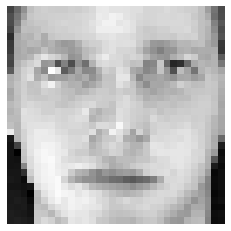

In [3]:
# Display a single example.
show_single_face(data[0, :])

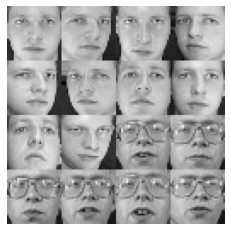

In [4]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [5]:
# normalization 
data = data / 255

# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares (13 Marks in Total)
### 3.1 Implementation (5 Marks, Easy)
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [6]:
def l2_rls_train(data, labels, reg
          ):
    """
    This function minimizes the sum of squares error loss.
    It takes in the training data and its corresponding labels, and 
    a regularization parameter. 
    First X tilde is calculated by appending a column of zeroes to the input matrix. 
    Then, it checks the regularization parameter- if set to zero, the function uses 
    the pseudoinverse to calculate the weights. Otherwise, it compares the number of rows
    and columns to decide how to calculate- in some instances the system is undetermined,
    so it takes different approaches to this calculation. 
    X tilde, the input labels, and the regularization parameter are then 
    all used in the regular sum of squares error loss minimization function, and 
    the calculated coefficient matrix is returned.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    rows, cols = X.shape
    # Expand X with a column of ones.
    X_tilde = np.c_[np.ones(rows), data]
    # Compute the coefficient vector.
    if reg != 0:
        if rows > cols:
            a = X_tilde.T @ X_tilde
            r,c = a.shape
            b = np.linalg.inv(a+reg*np.identity(r))
            c = b @ X_tilde.T
            d = c @ y
            t = d
        else:
            a = X_tilde @ X_tilde.T
            r, c = a.shape
            b = np.linalg.inv(a+reg*np.identity(r))
            c = X_tilde.T @ b
            t = c @ y
    else:
        w = np.linalg.pinv(X_tilde)
        t = w @ y
            
    w = t
    # Return model parameters.
    return w


Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [7]:
def l2_rls_predict(w, data):
    """
    This function takes the dot product of the query data, 
    inserts a 1 in the first spot, and multiplies that by the transpose of the 
    calculated weight vectors, returning this predicted output.

    data: type and description of "data"
    w: type and description of "w"

    Returns: type and description of the returned variable(s).
    """
    
    predicted_y = w.T @ np.insert(data,0,1)
    
    
    return predicted_y


#### Report

Explain briefly the knowledge supported your implementation and your design step by step.

### 3.2 Experiments (2 experiments to be implemented) 

Use your implemented functions to perform the following experiments. Experiment 1 is compulsory. Between Experiment 2 and Experiment 3, choose one as you like.

#### Experiment 1: Binary Classification (4 Marks, Normal)

Start with a binary classification to classify face images for subjects “1” and “30”.

Train three classifiers:
<br>Classifier 1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” for training a linear model, and use the threshold $T= 0$ to obtain the class prediction.
<br>Classifier 2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” for training a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
<br>Classifier 3. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” for training a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [8]:
# Your code goes here

In [9]:
correct1 = []
for q in range(50):    
    tr_ind, te_ind = partition_data(labels, num_per_class=3)
    tr_data = data[tr_ind, :]
    tr_label = labels[tr_ind]
    te_data = data[te_ind, :]
    te_label = labels[te_ind]


    tr_data = np.c_[tr_data, tr_label]
    # set class labels to -1 and 1 for data from classes 1 and 30, then get rid of everything else.
    tr_data = [x for x in tr_data if (x[-1] == 1 or x[-1] == 30)]
    tr_labs130 = np.array([x[-1] for x in tr_data])
    tr_data130 = np.array([x[:-1] for x in tr_data])

    te_data = np.c_[te_data, te_label]
    te_data = [x for x in te_data if (x[-1] == 1 or x[-1] == 30)]
    te_labs130 = np.array([x[-1] for x in te_data])
    te_data130 = np.array([x[:-1] for x in te_data])

    for i in range(len(tr_labs130)):
        if tr_labs130[i] == 1:
            tr_labs130[i] = -1
        elif tr_labs130[i] == 30:
            tr_labs130[i] = 1

    for i in range(len(te_labs130)):
        if te_labs130[i] == 1:
            te_labs130[i] = -1
        elif te_labs130[i] == 30:
            te_labs130[i] = 1
            
    # train model, predict testing output
    w = l2_rls_train(tr_data130, tr_labs130, 0)
    p = [l2_rls_predict(w, x) for x in te_data130]
    
    
    # determine training and testing accuracies
    for i in range(len(p)):
        if (p[i] < 0 and te_labs130[i] == -1) or (p[i] >= 0 and te_labs130[i] == 1):
            correct1.append(1)
        else:
            correct1.append(0)
    correct1_training = []
    p = [l2_rls_predict(w, x) for x in tr_data130]
    for i in range(len(p)):
        if (p[i] < 0 and tr_labs130[i] == -1) or (p[i] >= 0 and tr_labs130[i] == 1):
            correct1_training.append(1)
        else:
            correct1_training.append(0)

Repeat the same experiment for classifier 2.

In [10]:
correct2 = []
for q in range(50):    
    tr_ind, te_ind = partition_data(labels, num_per_class=3)
    tr_data = data[tr_ind, :]
    tr_label = labels[tr_ind]
    te_data = data[te_ind, :]
    te_label = labels[te_ind]

    # same as previous experiment, but with different labels used- 0 and 1, with threshold of .5
    tr_data = np.c_[tr_data, tr_label]

    tr_data = [x for x in tr_data if (x[-1] == 1 or x[-1] == 30)]
    tr_labs130 = np.array([x[-1] for x in tr_data])
    tr_data130 = np.array([x[:-1] for x in tr_data])

    te_data = np.c_[te_data, te_label]
    te_data = [x for x in te_data if (x[-1] == 1 or x[-1] == 30)]
    te_labs130 = np.array([x[-1] for x in te_data])
    te_data130 = np.array([x[:-1] for x in te_data])

    for i in range(len(tr_labs130)):
        if tr_labs130[i] == 1:
            tr_labs130[i] = 0
        elif tr_labs130[i] == 30:
            tr_labs130[i] = 1

    for i in range(len(te_labs130)):
        if te_labs130[i] == 1:
            te_labs130[i] = 0
        elif te_labs130[i] == 30:
            te_labs130[i] = 1
    
    # train and predict output for training and testing data, threshold of .5
    w = l2_rls_train(tr_data130, tr_labs130, 0)
    p = [l2_rls_predict(w, x) for x in te_data130]
    for i in range(len(p)):
        if (p[i] < .5 and te_labs130[i] == 0) or (p[i] >= .5 and te_labs130[i] == 1):
            correct2.append(1)
        else:
            correct2.append(0)
    correct2_training = []
    p = [l2_rls_predict(w, x) for x in tr_data130]
    for i in range(len(p)):
        if (p[i] < .5 and tr_labs130[i] == 0) or (p[i] >= .5 and tr_labs130[i] == 1):
            correct2_training.append(1)
        else:
            correct2_training.append(0)


Repeat the same experiment for classifier 3.

In [25]:
correct3 = []
for q in range(50):    
    tr_ind, te_ind = partition_data(labels, num_per_class=3)
    tr_data = data[tr_ind, :]
    tr_label = labels[tr_ind]
    te_data = data[te_ind, :]
    te_label = labels[te_ind]


    tr_data = np.c_[tr_data, tr_label]
    # same as previous experiments, but use 1 and 30 as class labels

    tr_data = [x for x in tr_data if (x[-1] == 1 or x[-1] == 30)]
    tr_labs130 = np.array([x[-1] for x in tr_data])
    tr_data130 = np.array([x[:-1] for x in tr_data])

    te_data = np.c_[te_data, te_label]
    te_data = [x for x in te_data if (x[-1] == 1 or x[-1] == 30)]
    te_labs130 = np.array([x[-1] for x in te_data])
    te_data130 = np.array([x[:-1] for x in te_data])

    # train model, predict for training and testing data with threshold of 15.5
    w = l2_rls_train(tr_data130, tr_labs130, 0)
    p = [l2_rls_predict(w, x) for x in te_data130]
    for i in range(len(p)):
        if (p[i] < 15.5 and te_labs130[i] == 1) or (p[i] >= 15.5 and te_labs130[i] == 30):
            correct3.append(1)
        else:
            correct3.append(0)
    correct3_training = []
    p = [l2_rls_predict(w, x) for x in tr_data130]
    for i in range(len(p)):
        if (p[i] < 15.5 and tr_labs130[i] == 1) or (p[i] >= 15.5 and tr_labs130[i] == 30):
            correct3_training.append(1)
        else:
            correct3_training.append(0)


Print out the mean and the std values of the test errors of the three classifiers.

In [26]:
print("***CLASSIFIER 1***")
print("MEAN TESTING ERROR: "+ str(100*(1-np.mean(correct1))) +"%")
print("MEAN TRAINING ACCURACY: "+str(100*(np.mean(correct1_training)))+"%")
print("STD:", np.std(correct1))
print("***CLASSIFIER 2***")
print("MEAN TESTING ERROR: " + str(100*(1-np.mean(correct2)))+"%")
print("MEAN TRAINING ACCURACY: "+str(100*(np.mean(correct2_training)))+"%")
print("STD:", np.std(correct2))
print("***CLASSIFIER 3***")
print("MEAN TESTING ERROR: " + str(100*(1-np.mean(correct3)))+"%")
print("MEAN TRAINING ACCURACY: "+str(100*(np.mean(correct3_training)))+"%")
print("STD:", np.std(correct3))

***CLASSIFIER 1***
MEAN TESTING ERROR: 6.571428571428573%
MEAN TRAINING ACCURACY: 100.0%
STD: 0.24778199766598652
***CLASSIFIER 2***
MEAN TESTING ERROR: 8.714285714285719%
MEAN TRAINING ACCURACY: 100.0%
STD: 0.2820442865789639
***CLASSIFIER 3***
MEAN TESTING ERROR: 8.14285714285714%
MEAN TRAINING ACCURACY: 100.0%
STD: 0.27349215561634205


#### Report

Explain the classification steps. Does changing the class labels impact the model performance? Explain why it does/doesn't impact.  What training accuracies do you obtain with your linear classifier? Analyse the reason.

#### Experiment 2: Multi-class Classification (4 Marks, Normal)

Now, proceed to the multi-class classification task to classify face images for all the 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

In [13]:
# Your code goes here
# Note that you may find it helpful to use one-hot encoding to deal with multi-class labels

 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

In [14]:
# Your code goes here

 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

In [15]:
# Your code goes here

#### Report

Explain the classification steps. How do you pick the most difficult and easiest subjects to classify,  analyse the results.

#### Experiment 3: Face Completion (4 Marks, Normal)

The task is to predic the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [16]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

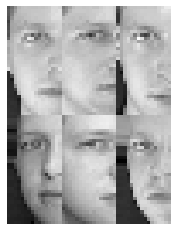

In [17]:
show_split_faces(left[:6, :], num_per_row=3)

Build a face completion model using your functions implemented earlier. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [18]:
def train_model(faces):
    """
    This function takes a matrix of training faces, splits them,
    and then uses the l2 rls function to predict the output. Instead of the labels
    being single values, the labels are the right side of the face, and the training
    data is the left side of the face. The psuedoinverse function is used to calculate 
    the weights.
    """
    l,r = split_left_right(faces)
    return l2_rls_train(l,r,0)
def predict_face(w, l):
    """
    The face prediction simply calls the rls function using the weights and the left side 
    of the face, and returns the right side of the face. 
    """
    
    return l2_rls_predict(w, l)

# partition the data
tr_ind, te_ind = partition_data(labels, num_per_class=5)
tr_data = data[tr_ind, :]
te_data = data[te_ind, :]

#train model, initialize prediction arrays
w = train_model(tr_data)
pred_training = np.array([])
pred_testing = np.array([])

# split faces, get predicted output for training data
l,r = split_left_right(tr_data)
pred_training = np.array([predict_face(w, image) for image in l])
faces_training = join_left_right(l, pred_training)

# get predicted output for testing data
l,r = split_left_right(te_data)
pred_testing = np.array([predict_face(w, image) for image in l])
faces_testing = join_left_right(l, pred_testing)

# calculate absolute percentage error for training and testing
difference = np.mean(np.abs(tr_data-faces_training)/tr_data*100)
print("Absolute percentage error for training: " +str(difference)+"%")
difference = np.mean(np.abs(te_data-faces_testing)/te_data*100)
print("Absolute percentage error for testing: " +str(difference)+"%")


Absolute percentage error for training: 2.1895097431068718e-13%
Absolute percentage error for testing: 11.325474136754565%


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

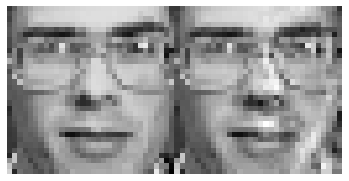

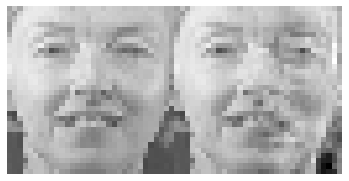

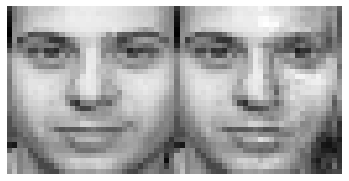

In [19]:
import random
r,c = faces_testing.shape

for i in range(3):
    choice = random.randint(0,r)
    out = np.array([te_data[choice], faces_testing[choice]])
    show_faces(out, num_per_row = 2)

#### Report

Analyse results of face completion model, how well your model performed, how it can be improved? 


## 4. Gradient descent for training linear least squares model (5 Marks in Total, Normal)

Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [20]:
def lls_gd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    The gradient descent training function takes in training labels and data, 
    a learning rate to decide how much each iteration changes the calculated weights,
    and an iteration number N that decides how many weight updates will occur.
    Weights are all initialized to zero, and empty arrays for storing the weights and cost by iteration
    are initialized.
    The gradient descent is calculated using the regular solution for linear least squares model.
    Then cost, the sum of squares error loss given the current weights, is calculated- the goal is to minimize this. 
    At each update, the next weight is calculated by subtracting the new gradient descent multiplied by the learning 
    rate from the current weights.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    row, col = X.shape
    Xtilde = np.c_[np.ones(row), X]

    # Weight initialization
    w = np.array([0 for i in range(col+1)])
    w_all = np.array([])
    cost_all = np.array([])
    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear least squares model
        a = Xtilde.T @ Xtilde
        b = a @ w
        c = Xtilde.T @ y
        gd = b - c
        cost = .5 * np.sum([(w.T @ Xtilde[j] - y[j]) ** 2 for j in range(row)])
        
        # Weight update
        w = w - learning_rate*gd
        
        
        # save w and cost of each iteration in w_all and cost_all 
        w_all = np.append(w_all,w)
        cost_all = np.append(cost_all, np.array(cost))
      
    
    # Return model parameters.
    return np.array(cost_all), np.array(w_all)


Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it compiles. 

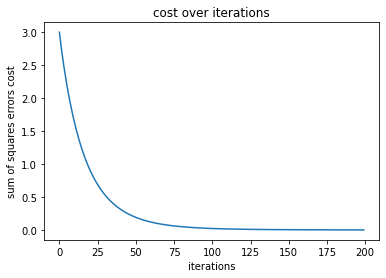

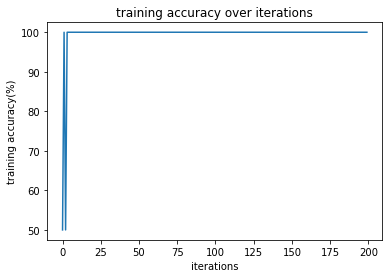

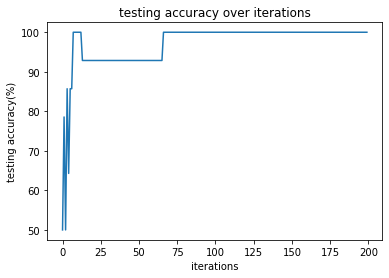

In [21]:
import matplotlib.pyplot as plt

tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]


# concatenated labels and training data, and filter dataset based on this value
# keep 1 and 30, and then set corresponding labels as -1 and 1 for all values left.
tr_data = np.c_[tr_data, tr_label]

tr_data = [x for x in tr_data if (x[-1] == 1 or x[-1] == 30)]
tr_labs130 = np.array([x[-1] for x in tr_data])
tr_data130 = np.array([x[:-1] for x in tr_data])

te_data = np.c_[te_data, te_label]
te_data = [x for x in te_data if (x[-1] == 1 or x[-1] == 30)]
te_labs130 = np.array([x[-1] for x in te_data])
te_data130 = np.array([x[:-1] for x in te_data])


for i in range(len(tr_labs130)):
    if tr_labs130[i] == 1:
        tr_labs130[i] = -1
    elif tr_labs130[i] == 30:
        tr_labs130[i] = 1

for i in range(len(te_labs130)):
    if te_labs130[i] == 1:
        te_labs130[i] = -1
    elif te_labs130[i] == 30:
        te_labs130[i] = 1

# train model and get predicted output
c,w = lls_gd_train(tr_data130, tr_labs130, 10**-3, 200)
w = np.reshape(w, (200,len(tr_data130[0])+1))
row, col = tr_data130.shape
tr_d_tilde = np.array([np.insert(sub, 0, 1) for sub in tr_data130])
pred_out_tr = np.array([[weight.T @ tilde for tilde in tr_d_tilde] for weight in w])

correct_tr = [[] for i in range(200)]

# determine if predicted output passes threshold value.
for i in range(len(pred_out_tr)):
    for j in range(len(pred_out_tr[i])):
        if (pred_out_tr[i][j] < 0 and tr_labs130[j] == -1) or (pred_out_tr[i][j] >= 0 and tr_labs130[j] == 1):
            correct_tr[i].append(1)
        else:
            correct_tr[i].append(0)

acc_tr = np.array([np.mean(correct_tr[i])*100 for i in range(len(correct_tr))])

# get predicted output for testing data

correct_te = [[] for i in range(200)]
row, col = te_data130.shape
te_d_tilde = np.array([np.insert(sub, 0, 1) for sub in te_data130])
pred_out_te = np.array([[weight.T @ tilde for tilde in te_d_tilde] for weight in w])

# determine if predicted output passes threshold value.
for i in range(len(pred_out_te)):
    for j in range(len(pred_out_te[i])):
        if (pred_out_te[i][j] < 0 and te_labs130[j] == -1) or (pred_out_te[i][j] >= 0 and te_labs130[j] == 1):
            correct_te[i].append(1)
        else:
            correct_te[i].append(0)

acc_te = np.array([np.mean(correct_te[i])*100 for i in range(len(correct_te))])



plot1 = plt.figure(1)
plt.plot(range(len(c)), c)
plt.xlabel("iterations")
plt.ylabel("sum of squares errors cost")
plt.title("cost over iterations")
plot2 = plt.figure(2)
plt.plot(range(len(acc_tr)), acc_tr)
plt.title("training accuracy over iterations")
plt.xlabel("iterations")
plt.ylabel("training accuracy(%)")
plot3 = plt.figure(3)
plt.plot(range(len(acc_te)), acc_te)
plt.title("testing accuracy over iterations")
plt.xlabel("iterations")
plt.ylabel("testing accuracy(%)")
plt.show()

Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it compiles. 

C:\Users\szure\AppData\Local\Temp/ipykernel_23116/236344583.py:38: RuntimeWarning: overflow encountered in double_scalars
  cost = .5 * np.sum([(w.T @ Xtilde[j] - y[j]) ** 2 for j in range(row)])


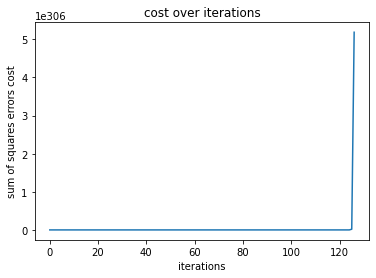

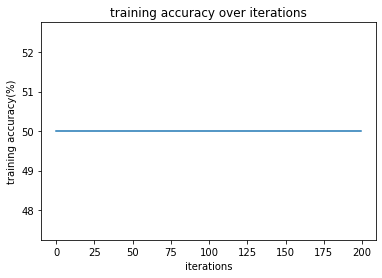

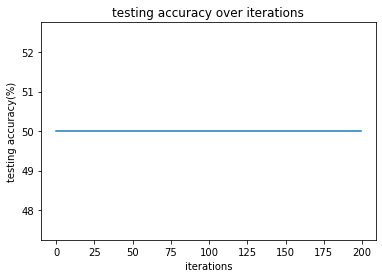

In [22]:
import matplotlib.pyplot as plt

tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

tr_data = np.c_[tr_data, tr_label]

# concatenated labels and training data, and filter dataset based on this value
# keep 1 and 30, and then set corresponding labels as -1 and 1 for all values left.
tr_data = [x for x in tr_data if (x[-1] == 1 or x[-1] == 30)]
tr_labs130 = np.array([x[-1] for x in tr_data])
tr_data130 = np.array([x[:-1] for x in tr_data])

te_data = np.c_[te_data, te_label]
te_data = [x for x in te_data if (x[-1] == 1 or x[-1] == 30)]
te_labs130 = np.array([x[-1] for x in te_data])
te_data130 = np.array([x[:-1] for x in te_data])

for i in range(len(tr_labs130)):
    if tr_labs130[i] == 1:
        tr_labs130[i] = -1
    elif tr_labs130[i] == 30:
        tr_labs130[i] = 1

for i in range(len(te_labs130)):
    if te_labs130[i] == 1:
        te_labs130[i] = -1
    elif te_labs130[i] == 30:
        te_labs130[i] = 1
        
        
# train model and get predicted output
c,w = lls_gd_train(tr_data130, tr_labs130, 10**-2, 200)
w = np.reshape(w, (200,len(tr_data130[0])+1))
row, col = tr_data130.shape
tr_d_tilde = np.array([np.insert(sub, 0, 1) for sub in tr_data130])
pred_out_tr = np.array([[weight.T @ tilde for tilde in tr_d_tilde] for weight in w])

correct_tr = [[] for i in range(200)]

# determine if predicted output passes threshold value.
for i in range(len(pred_out_tr)):
    for j in range(len(pred_out_tr[i])):
        if (pred_out_tr[i][j] < 0 and tr_labs130[j] == -1) or (pred_out_tr[i][j] >= 0 and tr_labs130[j] == 1):
            correct_tr[i].append(1)
        else:
            correct_tr[i].append(0)

acc_tr = np.array([np.mean(correct_tr[i])*100 for i in range(len(correct_tr))])

correct_te = [[] for i in range(200)]
row, col = te_data130.shape
te_d_tilde = np.array([np.insert(sub, 0, 1) for sub in te_data130])
pred_out_te = np.array([[weight.T @ tilde for tilde in te_d_tilde] for weight in w])

for i in range(len(pred_out_te)):
    for j in range(len(pred_out_te[i])):
        if (pred_out_te[i][j] < 0 and te_labs130[j] == -1) or (pred_out_te[i][j] >= 0 and te_labs130[j] == 1):
            correct_te[i].append(1)
        else:
            correct_te[i].append(0)

acc_te = np.array([np.mean(correct_te[i])*100 for i in range(len(correct_te))])



plot1 = plt.figure(1)
plt.plot(range(len(c)), c)
plt.xlabel("iterations")
plt.ylabel("sum of squares errors cost")
plt.title("cost over iterations")
plot2 = plt.figure(2)
plt.plot(range(len(acc_tr)), acc_tr)
plt.title("training accuracy over iterations")
plt.xlabel("iterations")
plt.ylabel("training accuracy(%)")
plot3 = plt.figure(3)
plt.plot(range(len(acc_te)), acc_te)
plt.title("testing accuracy over iterations")
plt.xlabel("iterations")
plt.ylabel("testing accuracy(%)")
plt.show()

#### Report

How did you choose the learning rate and iteration number, explain your results.

## 5. Compare with stochastic gradient descent training (7 Marks In Total)
### 5.1 SGD Implementation (2 Marks, Normal)
Replace the gradient descent approach that you did in 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt the similar implementation template as used in your `lls_gd_train` function.

In [23]:
def lls_sgd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    The stochastic gradient descent is built on the same framework as the previous gradient decent function.
    It works by calculating the gradient at each iteration using a single, randomly chosen input vector, 
    instead of by using the entirity of the data set. The cost calculation is still performed in the same way.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    import random
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    row, col = X.shape
    Xtilde = np.c_[np.ones(row), X]

    # Weight initialization
    w = np.array([0 for i in range(col+1)])
    w_all = np.array([])
    cost_all = np.array([])
    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear least squares model
        choice = random.randint(0, len(Xtilde)-1)
        r = Xtilde[choice]
        a = r.T @ r
        b = a * w
        c = r.T * y[choice]
        gd = b - c
        cost = .5 * np.sum([(w.T @ Xtilde[j] - y[j]) ** 2 for j in range(row)])
        
        # Weight update
        w = w - learning_rate*gd
        
        
        # save w and cost of each iteration in w_all and cost_all 
        w_all = np.append(w_all,w)
        cost_all = np.append(cost_all, np.array(cost))
      
    
    # Return model parameters.
    return np.array(cost_all), np.array(w_all)

### 5.2 Experiment Design (5 Marks, Hard)
Design and implement an appropriate experiment to demonstrate the perforamnce and behaviour difference between gradient descent and stochastic gradient descent. 


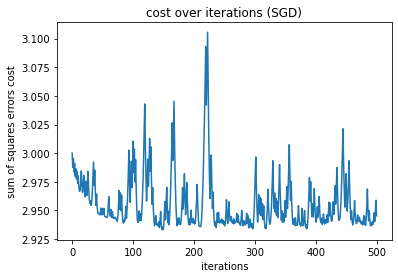

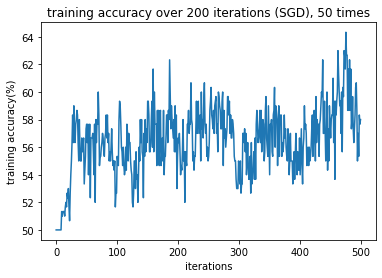

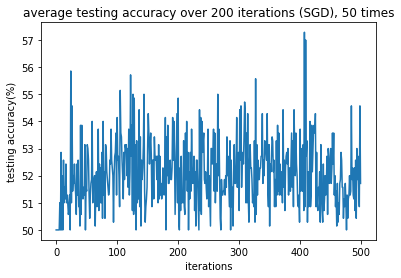

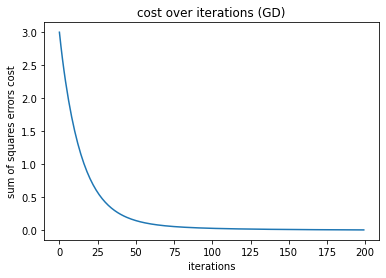

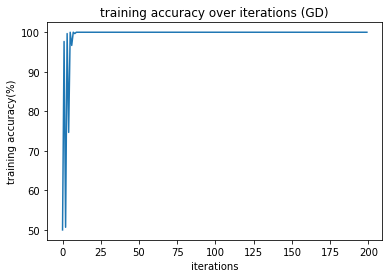

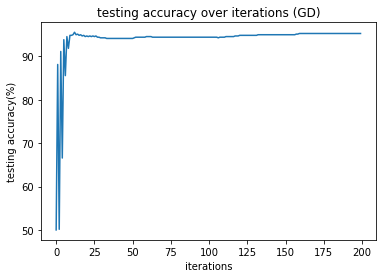

Average Time (seconds) to train SGD model for binary classification, 200 iterations, 3 samples per class:  0.25763626600000017
Average Time (seconds) to train GD model for binary classification, 200 iterations, 3 samples per class:  1.0325865440000002


In [24]:
import matplotlib.pyplot as plt
import time
costs_avg_sgd = []
teaccs_avg_sgd = []
traccs_avg_sgd = []
times_sgd = []
for q in range(50):
    tr_ind, te_ind = partition_data(labels, num_per_class=3)
    tr_data = data[tr_ind, :]
    tr_label = labels[tr_ind]
    te_data = data[te_ind, :]
    te_label = labels[te_ind]

    tr_data = np.c_[tr_data, tr_label]

    tr_data = [x for x in tr_data if (x[-1] == 1 or x[-1] == 30)]
    tr_labs130 = np.array([x[-1] for x in tr_data])
    tr_data130 = np.array([x[:-1] for x in tr_data])

    te_data = np.c_[te_data, te_label]
    te_data = [x for x in te_data if (x[-1] == 1 or x[-1] == 30)]
    te_labs130 = np.array([x[-1] for x in te_data])
    te_data130 = np.array([x[:-1] for x in te_data])

    for i in range(len(tr_labs130)):
        if tr_labs130[i] == 1:
            tr_labs130[i] = -1
        elif tr_labs130[i] == 30:
            tr_labs130[i] = 1

    for i in range(len(te_labs130)):
        if te_labs130[i] == 1:
            te_labs130[i] = -1
        elif te_labs130[i] == 30:
            te_labs130[i] = 1

    start_sgd = time.perf_counter()
    c,w = lls_sgd_train(tr_data130, tr_labs130, 10**-4, 500)
    stop_sgd_train = time.perf_counter()
    sgd_train_time = stop_sgd_train - start_sgd
    times_sgd.append(sgd_train_time)
    w = np.reshape(w, (500,len(tr_data130[0])+1))
    row, col = tr_data130.shape
    tr_d_tilde = np.array([np.insert(sub, 0, 1) for sub in tr_data130])
    pred_out_tr = np.array([[weight.T @ tilde for tilde in tr_d_tilde] for weight in w])


    correct_tr = [[] for i in range(500)]

    for i in range(len(pred_out_tr)):
        for j in range(len(pred_out_tr[i])):
            if (pred_out_tr[i][j] < -.2 and tr_labs130[j] == -1) or (pred_out_tr[i][j] >= -.2 and tr_labs130[j] == 1):
                correct_tr[i].append(1)
            else:
                correct_tr[i].append(0)

    acc_tr = np.array([np.mean(correct_tr[i])*100 for i in range(len(correct_tr))])
    traccs_avg_sgd.append(acc_tr)
    correct_te = [[] for i in range(500)]
    row, col = te_data130.shape
    te_d_tilde = np.array([np.insert(sub, 0, 1) for sub in te_data130])
    pred_out_te = np.array([[weight.T @ tilde for tilde in te_d_tilde] for weight in w])
    for i in range(len(pred_out_te)):
        for j in range(len(pred_out_te[i])):
            if (pred_out_te[i][j] < 0 and te_labs130[j] == -1) or (pred_out_te[i][j] >= 0 and te_labs130[j] == 1):
                correct_te[i].append(1)
            else:
                correct_te[i].append(0)


    acc_te = np.array([np.mean(correct_te[i])*100 for i in range(len(correct_te))])
    teaccs_avg_sgd.append(acc_te)
#print(pred_out_tr[-1])
#print(tr_labs130)
teaccs_avg_sgd = np.mean(teaccs_avg_sgd, axis = 0)
traccs_avg_sgd = np.mean(traccs_avg_sgd, axis = 0)
plot1 = plt.figure(1)
plt.plot(range(len(c)), c)
plt.xlabel("iterations")
plt.ylabel("sum of squares errors cost")
plt.title("cost over iterations (SGD)")
plot2 = plt.figure(2)
plt.plot(range(len(traccs_avg_sgd)), traccs_avg_sgd)
plt.title("training accuracy over 200 iterations (SGD), 50 times")
plt.xlabel("iterations")
plt.ylabel("training accuracy(%)")
plot3 = plt.figure(3)
plt.plot(range(len(teaccs_avg_sgd)), teaccs_avg_sgd)
plt.title("average testing accuracy over 200 iterations (SGD), 50 times")
plt.xlabel("iterations")
plt.ylabel("testing accuracy(%)")
plt.show()

teaccs_avg_gd = []
traccs_avg_gd= []
times_gd = []
for q in range(50):
    tr_ind, te_ind = partition_data(labels, num_per_class=3)
    tr_data = data[tr_ind, :]
    tr_label = labels[tr_ind]
    te_data = data[te_ind, :]
    te_label = labels[te_ind]

    tr_data = np.c_[tr_data, tr_label]

    tr_data = [x for x in tr_data if (x[-1] == 1 or x[-1] == 30)]
    tr_labs130 = np.array([x[-1] for x in tr_data])
    tr_data130 = np.array([x[:-1] for x in tr_data])

    te_data = np.c_[te_data, te_label]
    te_data = [x for x in te_data if (x[-1] == 1 or x[-1] == 30)]
    te_labs130 = np.array([x[-1] for x in te_data])
    te_data130 = np.array([x[:-1] for x in te_data])

    for i in range(len(tr_labs130)):
        if tr_labs130[i] == 1:
            tr_labs130[i] = -1
        elif tr_labs130[i] == 30:
            tr_labs130[i] = 1

    for i in range(len(te_labs130)):
        if te_labs130[i] == 1:
            te_labs130[i] = -1
        elif te_labs130[i] == 30:
            te_labs130[i] = 1

    start_gd_train = time.perf_counter()
    c,w = lls_gd_train(tr_data130, tr_labs130, 10**-3, 200)
    stop_gd_train = time.perf_counter()
    gd_train_time = stop_gd_train - start_gd_train
    times_gd.append(gd_train_time)
    w = np.reshape(w, (200,len(tr_data130[0])+1))
    row, col = tr_data130.shape
    tr_d_tilde = np.array([np.insert(sub, 0, 1) for sub in tr_data130])
    pred_out_tr = np.array([[weight.T @ tilde for tilde in tr_d_tilde] for weight in w])

    correct_tr = [[] for i in range(200)]

    for i in range(len(pred_out_tr)):
        for j in range(len(pred_out_tr[i])):
            if (pred_out_tr[i][j] < 0 and tr_labs130[j] == -1) or (pred_out_tr[i][j] >= 0 and tr_labs130[j] == 1):
                correct_tr[i].append(1)
            else:
                correct_tr[i].append(0)

    acc_tr = np.array([np.mean(correct_tr[i])*100 for i in range(len(correct_tr))])
    traccs_avg_gd.append(acc_tr)

    
    correct_te = [[] for i in range(200)]
    row, col = te_data130.shape
    te_d_tilde = np.array([np.insert(sub, 0, 1) for sub in te_data130])
    pred_out_te = np.array([[weight.T @ tilde for tilde in te_d_tilde] for weight in w])

    for i in range(len(pred_out_te)):
        for j in range(len(pred_out_te[i])):
            if (pred_out_te[i][j] < 0 and te_labs130[j] == -1) or (pred_out_te[i][j] >= 0 and te_labs130[j] == 1):
                correct_te[i].append(1)
            else:
                correct_te[i].append(0)

    acc_te = np.array([np.mean(correct_te[i])*100 for i in range(len(correct_te))])
    teaccs_avg_gd.append(acc_te)

teaccs_avg_gd = np.mean(teaccs_avg_gd, axis = 0)
traccs_avg_gd = np.mean(traccs_avg_gd, axis = 0)

plot1 = plt.figure(1)
plt.plot(range(len(c)), c)
plt.xlabel("iterations")
plt.ylabel("sum of squares errors cost")
plt.title("cost over iterations (GD)")
plot2 = plt.figure(2)
plt.plot(range(len(traccs_avg_gd)), traccs_avg_gd)
plt.title("training accuracy over iterations (GD)")
plt.xlabel("iterations")
plt.ylabel("training accuracy(%)")
plot3 = plt.figure(3)
plt.plot(range(len(teaccs_avg_gd)), teaccs_avg_gd)
plt.title("testing accuracy over iterations (GD)")
plt.xlabel("iterations")
plt.ylabel("testing accuracy(%)")
plt.show()

print("Average Time (seconds) to train SGD model for binary classification, 200 iterations, 3 samples per class: ", np.mean(times_sgd))
print("Average Time (seconds) to train GD model for binary classification, 200 iterations, 3 samples per class: ", np.mean(times_gd))

#### Report  

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

#### Remember that all graphs should have axis labels and a title.